## pulizia file 

In [39]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [ ]:
false = pd.read_csv("/home/federica/LAB2/condivisi/uniprot_false.tsv", sep="\t", low_memory=False)
true = pd.read_csv("/home/federica/LAB2/condivisi/uniprot_true.tsv", sep="\t", low_memory=False)

In [41]:
columns_to_keep = ['Entry',	'Reviewed',	'Entry Name','Protein names','Gene Names','Organism','Protein families', 'Natural variant','CDD','DisProt',
                   'Reactome', 'Interacts with','Subunit structure','Gene Names (primary)','Organism (ID)','Gene Names (synonym)','Involvement in disease',
                   'Pharmaceutical use','ChEMBL','DrugBank','BindingDB','DrugCentral', 'Mutagenesis']
true = true[columns_to_keep]
false = false[columns_to_keep]

In [42]:

def process_involvement_in_disease(text):
    if pd.isna(text) or text.startswith("Note: "):
        return None
    diseases = []
    matches = re.findall(r"DISEASE: (.+?) \[MIM:\d+\]", text)
    for match in matches:
        diseases.append(match.strip())
    return "; ".join(diseases) if diseases else None


In [43]:
true["Involvement in disease"] = true["Involvement in disease"].apply(process_involvement_in_disease)
false["Involvement in disease"] = false["Involvement in disease"].apply(process_involvement_in_disease)

In [44]:
def process_natural_variant(variant_string):
    if not isinstance(variant_string, str):
        return None
    matches = re.findall(r'VARIANT (\d+); /note="(\w) -> (\w) \(in (.+?)\)";', variant_string)
    results = []
    
    for match in matches:
        position = match[0]
        from_aa = match[1]
        to_aa = match[2]
        info = match[3]
        dbsnp_match = re.search(r'dbSNP:[^;]+', info)
        if dbsnp_match:
            dbsnp_info = dbsnp_match.group(0)
            info = info.replace(dbsnp_info, '').strip()
        result = f"{from_aa}{position}{to_aa}: {info}"
        results.append(result.strip(': '))
    
    return '-'.join(results)

In [45]:
true["Natural variant"] = true["Natural variant"].apply(process_natural_variant)
false["Natural variant"] = false["Natural variant"].apply(process_natural_variant)

In [46]:
def process_mutagenesis(text):
    if pd.isna(text):
        return None
    mutagenesis_data = []
    pattern = re.compile(r"MUTAGEN (\d+(?:\.\.\d+)?); /note=\"(\w+)->(\w+): (.*?);")
    for match in pattern.finditer(text):
        position = match.group(1)
        original = match.group(2)
        new = match.group(3)
        description = match.group(4)
        mutagenesis_data.append(f"{original}{position}{new}: {description}")
    return "; ".join(mutagenesis_data) if mutagenesis_data else None

In [47]:
true["Mutagenesis"] = true["Mutagenesis"].apply(process_mutagenesis)
false["Mutagenesis"] = false["Mutagenesis"].apply(process_mutagenesis)

In [48]:
true.to_csv("/home/federica/LAB2/nuovo/uniprot_true_processed.tsv", sep="\t", index=False)
false.to_csv("/home/federica/LAB2/nuovo/uniprot_false_processed.tsv", sep="\t", index=False)

## Cluster su EGFR con funzione di BemisMurcko

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import AllChem, DataStructs, rdMolDescriptors, Descriptors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

In [50]:
act=pd.read_csv("/home/federica/LAB2/egfr_35/filtered_act/whole_dataset_out.csv")
perc = pd.read_csv("/home/federica/LAB2/egfr_35/filtered_perc/whole_dataset_out.csv")
df = pd.concat([act, perc], ignore_index=True)

In [51]:
df.columns
df.drop_duplicates(subset=['Molecule ChEMBL ID'], inplace=True)
df

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Compound Key,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,...,accession,protein_class_desc,mutation,mutant_known,mutant,shifted_mutation,Accession Code,Population,Quality,Class
0,CHEMBL574738,AST-487,1.0,AST-487,CCN1CCN(Cc2ccc(NC(=O)Nc3ccc(Oc4cc(NC)ncn4)cc3)...,Kd,'=',220.00,nM,6.66,...,P00533,enzyme; kinase; protein kinase; tk; egfr,True,True,G719C,"G717C,G718C,G720C,G721C",P00533,Plus,1,1.0
1,CHEMBL554,LAPATINIB,4.0,Lapatinib,CS(=O)(=O)CCNCc1ccc(-c2ccc3ncnc(Nc4ccc(OCc5ccc...,Kd,'=',0.92,nM,9.04,...,P00533,enzyme; kinase; protein kinase; tk; egfr,True,True,G719C,"G717C,G718C,G720C,G721C",P00533,Plus,1,1.0
2,CHEMBL124660,TANDUTINIB,2.0,MLN-518,COc1cc2c(N3CCN(C(=O)Nc4ccc(OC(C)C)cc4)CC3)ncnc...,Kd,'=',400.00,nM,6.40,...,P00533,enzyme; kinase; protein kinase; tk; egfr,True,True,L858R,"L856R,L857R,L859R,L860R",P00533,Plus,1,1.0
3,CHEMBL607707,PELITINIB,2.0,EKB-569,CCOc1cc2ncc(C#N)c(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)...,Kd,'=',0.44,nM,9.36,...,P00533,enzyme; kinase; protein kinase; tk; egfr,True,True,L861Q,"L859Q,L860Q,L862Q,L863Q",P00533,Plus,1,1.0
5,CHEMBL24828,VANDETANIB,4.0,ZD-6474,COc1cc2/c(=N/c3ccc(Br)cc3F)nc[nH]c2cc1OCC1CCN(...,Kd,'=',9.60,nM,8.02,...,P00533,enzyme; kinase; protein kinase; tk; egfr,True,True,G719C,"G717C,G718C,G720C,G721C",P00533,Plus,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4901,CHEMBL4285448,NaN,NaN,10Bb,CC(C)c1nc2c(Oc3ccc(NC(=O)c4cccn(-c5ccc(F)cc5)c...,Activity,'=',8.00,%,NaN,...,P00533,enzyme; kinase; protein kinase; tk; egfr,True,NaN,wild type,NaN,NaN,Less,2,1.0
4902,CHEMBL4285809,NaN,NaN,25,O=C(Nc1ccc(Oc2c(Br)cnc3[nH]cnc23)c(F)c1)c1cccn...,Activity,'=',1.00,%,NaN,...,P00533,enzyme; kinase; protein kinase; tk; egfr,True,NaN,wild type,NaN,NaN,Less,2,1.0
4903,CHEMBL1171523,NaN,NaN,3,CCN1CCN(Cc2ccc(NC(=O)c3ccc(C)c(C#Cc4cccnc4)c3)...,Inhibition,'=',100.00,%,NaN,...,P00533,enzyme; kinase; protein kinase; tk; egfr,True,True/True,L858R/T790M,"L856R,L857R,L859R,L860R/T788M,T789M,T791M,T792M",P00533,Less,3,1.0
4904,CHEMBL1170139,NaN,NaN,12,CCN1CCN(Cc2ccc(NC(=O)c3ccc(C)c(C#Cc4cnc5[nH]cc...,Inhibition,'=',100.00,%,NaN,...,P00533,enzyme; kinase; protein kinase; tk; egfr,True,True/True,L858R/T790M,"L856R,L857R,L859R,L860R/T788M,T789M,T791M,T792M",P00533,Less,3,1.0


In [52]:
def get_bemis_murcko_scaffold(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        scaffold = MurckoScaffold.GetScaffoldForMol(mol)
        return Chem.MolToSmiles(scaffold)
    return None

In [53]:
df["Scaffold"] = df["Smiles"].apply(get_bemis_murcko_scaffold)

In [54]:
def get_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fp, arr)
        return arr
    return np.zeros((2048,))

df["Fingerprint"] = df["Smiles"].apply(get_fingerprint)
fp_matrix = np.array(df["Fingerprint"].tolist())

[09:50:10] DEPRECATION WARNING: please use MorganGenerator
[09:50:10] DEPRECATION WARNING: please use MorganGenerator
[09:50:10] DEPRECATION WARNING: please use MorganGenerator
[09:50:10] DEPRECATION WARNING: please use MorganGenerator
[09:50:10] DEPRECATION WARNING: please use MorganGenerator
[09:50:10] DEPRECATION WARNING: please use MorganGenerator
[09:50:10] DEPRECATION WARNING: please use MorganGenerator
[09:50:10] DEPRECATION WARNING: please use MorganGenerator
[09:50:10] DEPRECATION WARNING: please use MorganGenerator
[09:50:10] DEPRECATION WARNING: please use MorganGenerator
[09:50:10] DEPRECATION WARNING: please use MorganGenerator
[09:50:10] DEPRECATION WARNING: please use MorganGenerator
[09:50:10] DEPRECATION WARNING: please use MorganGenerator
[09:50:10] DEPRECATION WARNING: please use MorganGenerator
[09:50:10] DEPRECATION WARNING: please use MorganGenerator
[09:50:10] DEPRECATION WARNING: please use MorganGenerator
[09:50:10] DEPRECATION WARNING: please use MorganGenerat

In [55]:
pca = PCA(n_components=50)
fp_pca = pca.fit_transform(fp_matrix)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(fp_pca)
df["TSNE1"], df["TSNE2"] = tsne_results[:, 0], tsne_results[:, 1]

In [56]:
df["Scaffold"] = df["Scaffold"].apply(lambda x: str(x) if isinstance(x, list) else x)
scaffold_dict = {scaffold: i for i, scaffold in enumerate(df["Scaffold"].unique())}
df["Cluster_ID"] = df["Scaffold"].map(scaffold_dict)

In [57]:
df.to_csv("/home/federica/LAB2/egfr_35/filtered_act/clustered_dataset.csv", index=False)


In [58]:
df.to_csv("/home/federica/LAB2/egfr_35/filtered_act/tsne.csv", index=False)

In [59]:
scaffolds = df["Scaffold"].unique()
color_map = ListedColormap(sns.color_palette("husl", len(scaffolds)))
palette = sns.color_palette(color_map.colors)


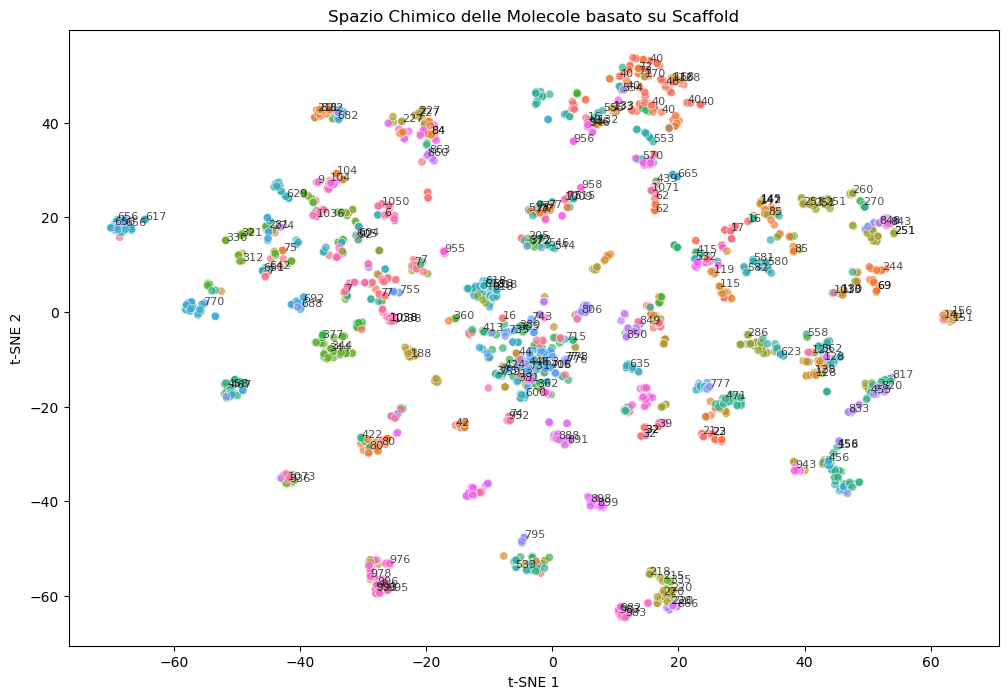

In [60]:
import numpy as np
np.random.seed(42)

plt.figure(figsize=(12, 8))
sns.scatterplot(x="TSNE1", y="TSNE2", hue="Scaffold", palette=palette, data=df, alpha=0.7, legend=False)

for i, row in df.iterrows():
    if row["Molecule Name"] == "Osimertinib" or np.random.rand() < 0.08:  
        plt.text(row["TSNE1"], row["TSNE2"], row["Cluster_ID"], fontsize=8, alpha=0.7)

plt.title("Spazio Chimico delle Molecole basato su Scaffold")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

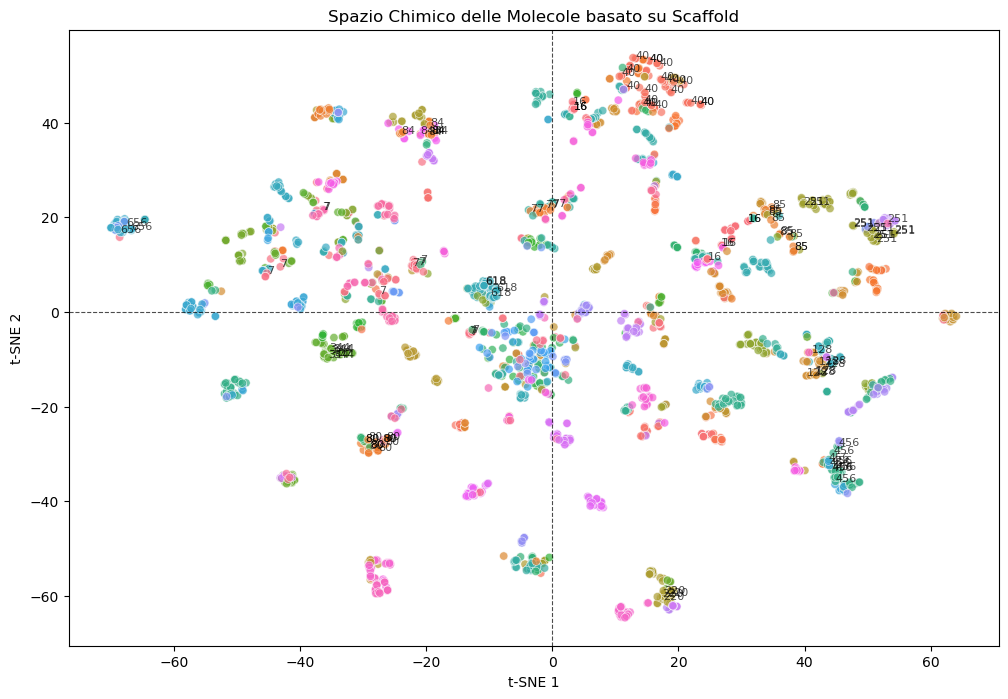

In [61]:
np.random.seed(42)

plt.figure(figsize=(12, 8))
sns.scatterplot(x="TSNE1", y="TSNE2", hue="Scaffold", palette=palette, data=df, alpha=0.7, legend=False)

clusters_in_red = {40, 251, 7, 456, 344, 16, 85, 80, 128, 220, 84, 656, 77, 618}
filtered_df = df[df["Cluster_ID"].isin(clusters_in_red)]

for i, row in filtered_df.iterrows():
    if np.random.rand() < 0.2: 
        plt.text(row["TSNE1"], row["TSNE2"], row["Cluster_ID"], fontsize=8, alpha=0.7)

plt.axhline(0, color='black', linewidth=0.8, linestyle='--', alpha=0.7)  
plt.axvline(0, color='black', linewidth=0.8, linestyle='--', alpha=0.7)  

plt.title("Spazio Chimico delle Molecole basato su Scaffold")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

## diversità dei cluster


In [62]:
print(df.columns)

Index(['Molecule ChEMBL ID', 'Molecule Name', 'Molecule Max Phase',
       'Compound Key', 'Smiles', 'Standard Type', 'Standard Relation',
       'Standard Value', 'Standard Units', 'pChEMBL Value',
       'Data Validity Comment', 'Potential Duplicate', 'Assay ChEMBL ID',
       'Assay Description', 'Assay Type', 'BAO Label', 'Assay Organism',
       'Assay Cell Type', 'Assay Variant Mutation', 'Target ChEMBL ID',
       'Target Name', 'Target Organism', 'Target Type', 'Document ChEMBL ID',
       'Source Description', 'Cell ChEMBL ID', 'Standard Text Value', 'Value',
       'family', 'accession', 'protein_class_desc', 'mutation', 'mutant_known',
       'mutant', 'shifted_mutation', 'Accession Code', 'Population', 'Quality',
       'Class', 'Scaffold', 'Fingerprint', 'TSNE1', 'TSNE2', 'Cluster_ID'],
      dtype='object')


In [63]:
def get_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)

In [64]:
print(df.columns)
df['Fingerprint'] = df['Smiles'].apply(get_fingerprint)
df = df[df['Fingerprint'].notna()]
group = df.groupby('Cluster_ID')

Index(['Molecule ChEMBL ID', 'Molecule Name', 'Molecule Max Phase',
       'Compound Key', 'Smiles', 'Standard Type', 'Standard Relation',
       'Standard Value', 'Standard Units', 'pChEMBL Value',
       'Data Validity Comment', 'Potential Duplicate', 'Assay ChEMBL ID',
       'Assay Description', 'Assay Type', 'BAO Label', 'Assay Organism',
       'Assay Cell Type', 'Assay Variant Mutation', 'Target ChEMBL ID',
       'Target Name', 'Target Organism', 'Target Type', 'Document ChEMBL ID',
       'Source Description', 'Cell ChEMBL ID', 'Standard Text Value', 'Value',
       'family', 'accession', 'protein_class_desc', 'mutation', 'mutant_known',
       'mutant', 'shifted_mutation', 'Accession Code', 'Population', 'Quality',
       'Class', 'Scaffold', 'Fingerprint', 'TSNE1', 'TSNE2', 'Cluster_ID'],
      dtype='object')


[09:50:19] DEPRECATION WARNING: please use MorganGenerator
[09:50:19] DEPRECATION WARNING: please use MorganGenerator
[09:50:19] DEPRECATION WARNING: please use MorganGenerator
[09:50:19] DEPRECATION WARNING: please use MorganGenerator
[09:50:19] DEPRECATION WARNING: please use MorganGenerator
[09:50:19] DEPRECATION WARNING: please use MorganGenerator
[09:50:19] DEPRECATION WARNING: please use MorganGenerator
[09:50:19] DEPRECATION WARNING: please use MorganGenerator
[09:50:19] DEPRECATION WARNING: please use MorganGenerator
[09:50:19] DEPRECATION WARNING: please use MorganGenerator
[09:50:19] DEPRECATION WARNING: please use MorganGenerator
[09:50:19] DEPRECATION WARNING: please use MorganGenerator
[09:50:19] DEPRECATION WARNING: please use MorganGenerator
[09:50:19] DEPRECATION WARNING: please use MorganGenerator
[09:50:19] DEPRECATION WARNING: please use MorganGenerator
[09:50:19] DEPRECATION WARNING: please use MorganGenerator
[09:50:19] DEPRECATION WARNING: please use MorganGenerat

In [65]:
def cluster_diversity(cluster_df):
    sims = []
    fingerprints = cluster_df["Fingerprint"].tolist()
    for i in range(len(fingerprints)):
        for j in range(i + 1, len(fingerprints)):
            sim = DataStructs.TanimotoSimilarity(fingerprints[i], fingerprints[j])
            sims.append(sim)
    if len(sims) == 0:
        return None, None
    return np.mean(sims), np.std(sims)

In [66]:
diversity_results = []
for cluster_id, cluster_df in group:
    mean, std = cluster_diversity(cluster_df)
    diversity_results.append({"Cluster_ID": cluster_id, "Mean_Similarity": mean, "Std_Similarity": std})
diversity_df = pd.DataFrame(diversity_results)
print(diversity_df)
diversity_df.to_csv("/home/federica/LAB2/egfr_qsar/cluster_diversity.csv", index=False)

      Cluster_ID  Mean_Similarity  Std_Similarity
0              0              NaN             NaN
1              1         0.730769        0.000000
2              2              NaN             NaN
3              3         0.371738        0.194419
4              4              NaN             NaN
...          ...              ...             ...
1080        1080              NaN             NaN
1081        1081         0.571429        0.000000
1082        1082              NaN             NaN
1083        1083              NaN             NaN
1084        1084              NaN             NaN

[1085 rows x 3 columns]


In [67]:

clusters_in_red = {40, 251, 7, 456, 344, 16, 85, 80, 128, 220, 84, 656, 77, 618}
filtered_df = df[df["Cluster_ID"].isin(clusters_in_red)]
def cluster_diversity(cluster_df):
    sims = []
    fingerprints = cluster_df["Fingerprint"].tolist()
    for i in range(len(fingerprints)):
        for j in range(i + 1, len(fingerprints)):
            sim = DataStructs.TanimotoSimilarity(fingerprints[i], fingerprints[j])
            sims.append(sim)
    if len(sims) == 0:
        return None, None
    return np.mean(sims), np.std(sims)
diversity_results = []
for cluster_id in clusters_in_red:
    cluster_df = filtered_df[filtered_df["Cluster_ID"] == cluster_id]
    mean_sim, std_sim = cluster_diversity(cluster_df)
    diversity_results.append({
        "Cluster_ID": cluster_id,
        "Num_Molecules": len(cluster_df),
        "Mean_Similarity": mean_sim,
        "Std_Similarity": std_sim
    })
diversity_df = pd.DataFrame(diversity_results)
diversity_df.to_csv("/home/federica/LAB2/egfr_qsar/inner_cluster_comparison.csv", index=False)
print(diversity_df)

    Cluster_ID  Num_Molecules  Mean_Similarity  Std_Similarity
0          128             28         0.717760        0.077035
1            7             47         0.382486        0.151369
2           40             82         0.534962        0.156899
3          456             46         0.673550        0.111711
4          618             23         0.565764        0.126247
5           77             23         0.564824        0.133502
6           16             32         0.465848        0.180641
7           80             29         0.661533        0.105462
8          656             24         0.756367        0.063225
9           84             24         0.637113        0.135819
10          85             30         0.596107        0.156332
11         344             33         0.564740        0.108376
12         251             54         0.589473        0.125440
13         220             25         0.570871        0.120730


In [ ]:
def calculate_tanimoto_similarity(smiles_list1, smiles_list2):

    fps1 = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s), 2) for s in smiles_list1 if Chem.MolFromSmiles(s)]
    fps2 = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s), 2) for s in smiles_list2 if Chem.MolFromSmiles(s)]
    
    similarities = []
    for fp1 in fps1:
        for fp2 in fps2:
            sim = DataStructs.TanimotoSimilarity(fp1, fp2)
            similarities.append(sim)
    
    avg_similarity = sum(similarities) / len(similarities) if similarities else 0
    return avg_similarity

def cluster_similarity_with_others(cluster_40_df, other_clusters_df):
    results = []
    smiles_40 = cluster_40_df["Smiles"].tolist()
    
    for cluster_id in other_clusters_df["Cluster_ID"].unique():
        if cluster_id == 40:
            continue
        
        cluster_df = other_clusters_df[other_clusters_df["Cluster_ID"] == cluster_id]
        smiles_other = cluster_df["Smiles"].tolist()
        set_similarity = calculate_tanimoto_similarity(smiles_40, smiles_other)
        
        results.append({
            "Cluster_40_vs_Cluster": cluster_id,
            "Set_Similarity": set_similarity
        })
    
    return pd.DataFrame(results)

cluster_40_df = filtered_df[filtered_df["Cluster_ID"] == 40]
other_clusters_df = filtered_df[filtered_df["Cluster_ID"] != 40]
similarity_df = cluster_similarity_with_others(cluster_40_df, other_clusters_df)
similarity_df.to_csv("/home/federica/LAB2/egfr_qsar/files/cluster_40_similarity.csv", index=False)
print(similarity_df)

[09:50:19] DEPRECATION WARNING: please use MorganGenerator
[09:50:19] DEPRECATION WARNING: please use MorganGenerator
[09:50:19] DEPRECATION WARNING: please use MorganGenerator
[09:50:19] DEPRECATION WARNING: please use MorganGenerator
[09:50:19] DEPRECATION WARNING: please use MorganGenerator
[09:50:19] DEPRECATION WARNING: please use MorganGenerator
[09:50:19] DEPRECATION WARNING: please use MorganGenerator
[09:50:19] DEPRECATION WARNING: please use MorganGenerator
[09:50:19] DEPRECATION WARNING: please use MorganGenerator
[09:50:19] DEPRECATION WARNING: please use MorganGenerator
[09:50:19] DEPRECATION WARNING: please use MorganGenerator
[09:50:19] DEPRECATION WARNING: please use MorganGenerator
[09:50:19] DEPRECATION WARNING: please use MorganGenerator
[09:50:19] DEPRECATION WARNING: please use MorganGenerator
[09:50:19] DEPRECATION WARNING: please use MorganGenerator
[09:50:19] DEPRECATION WARNING: please use MorganGenerator
[09:50:19] DEPRECATION WARNING: please use MorganGenerat

    Cluster_40_vs_Cluster  Set_Similarity
0                       7        0.189521
1                      16        0.332822
2                      77        0.182270
3                      80        0.156309
4                      84        0.209438
5                      85        0.236874
6                     128        0.262046
7                     220        0.154137
8                     251        0.245624
9                     344        0.132301
10                    456        0.183046
11                    618        0.183257
12                    656        0.187416


[09:50:20] DEPRECATION WARNING: please use MorganGenerator
[09:50:20] DEPRECATION WARNING: please use MorganGenerator
[09:50:20] DEPRECATION WARNING: please use MorganGenerator
[09:50:20] DEPRECATION WARNING: please use MorganGenerator
[09:50:20] DEPRECATION WARNING: please use MorganGenerator
[09:50:20] DEPRECATION WARNING: please use MorganGenerator
[09:50:20] DEPRECATION WARNING: please use MorganGenerator
[09:50:20] DEPRECATION WARNING: please use MorganGenerator
[09:50:20] DEPRECATION WARNING: please use MorganGenerator
[09:50:20] DEPRECATION WARNING: please use MorganGenerator
[09:50:20] DEPRECATION WARNING: please use MorganGenerator
[09:50:20] DEPRECATION WARNING: please use MorganGenerator
[09:50:20] DEPRECATION WARNING: please use MorganGenerator
[09:50:20] DEPRECATION WARNING: please use MorganGenerator
[09:50:20] DEPRECATION WARNING: please use MorganGenerator
[09:50:20] DEPRECATION WARNING: please use MorganGenerator
[09:50:20] DEPRECATION WARNING: please use MorganGenerat

## formatting clustered files 

In [69]:
df=pd.read_csv("/home/federica/LAB2/egfr_35/filtered_act/clustered_dataset.csv")

In [70]:
df.columns
df = df[['Molecule ChEMBL ID', 'Smiles', 'Standard Type','Standard Relation', 'Standard Value', 'Standard Units', 'Document ChEMBL ID']]
df['Smiles (RDKit Mol)']=''
df.columns

Index(['Molecule ChEMBL ID', 'Smiles', 'Standard Type', 'Standard Relation',
       'Standard Value', 'Standard Units', 'Document ChEMBL ID',
       'Smiles (RDKit Mol)'],
      dtype='object')

In [71]:
df.to_csv("/home/federica/LAB2/egfr_qsar/egfr.csv", index=False)

## Cluster su EGFR
Conto le molecole che fanno parte di uno stesso cluster su tutto egfr

In [72]:
cluster= pd.read_csv('/home/federica/LAB2/egfr_35/filtered_act/clustered_dataset.csv')
cluster_counts = cluster.groupby('Cluster_ID').size().to_dict()

In [73]:
cluster_counts_df = pd.DataFrame(list(cluster_counts.items()), columns=['Cluster_ID', 'Count'])
cluster_counts_df.to_csv('/home/federica/LAB2/egfr_35/filtered_act/cluster_counts.csv', index=False, sep=',')

## file cluster

In [74]:
f=pd.read_csv("/home/federica/LAB2/egfr_35/filtered_act/clustered_dataset.csv")
df = f[f['Cluster_ID'] == 618]
df = df[['Molecule ChEMBL ID', 'Smiles', 'Standard Type','Standard Relation', 'Standard Value', 'Standard Units', 'Document ChEMBL ID']]
df['Smiles (RDKit Mol)']=''
df.to_csv("/home/federica/LAB2/egfr_qsar/cluster_618.csv", index=False)

## modifica scaffold principale con carbonio

In [ ]:
import pandas as pd
import random
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold

In [ ]:


df = pd.read_csv("/home/federica/LAB2/egfr_qsar/cluster_220.csv")

def carbon_scaffold_from_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    scaffold = MurckoScaffold.GetScaffoldForMol(mol)
    if scaffold is None:
        return None
    for atom in scaffold.GetAtoms():
        atom.SetAtomicNum(6) 
    return scaffold

def apply_scaffold_swap(original_smiles):
    mol = Chem.MolFromSmiles(original_smiles)
    if mol is None:
        return None
    scaffold = MurckoScaffold.GetScaffoldForMol(mol)
    if scaffold is None:
        return None
    carbon_scaffold = Chem.Mol(scaffold)
    for atom in carbon_scaffold.GetAtoms():
        atom.SetAtomicNum(6)
    rxn = AllChem.ReplaceSubstructs(mol, scaffold, carbon_scaffold)
    if rxn:
        modified_mol = rxn[0]
        return Chem.MolToSmiles(modified_mol)
    return None

new_rows = []

for idx, row in df.iterrows():
    smiles = row["Smiles"]
    mol_id = row["Molecule ChEMBL ID"]
    new_smiles = apply_scaffold_swap(smiles)
    new_row = {
        "Molecule ChEMBL ID": mol_id + "_CARBON_SCAFFOLD",
        "Smiles": new_smiles,
        "Standard Type": row["Standard Type"],
        "Standard Relation": "=",
        "Standard Value": random.randint(10000, 100000),
        "Standard Units": row["Standard Units"],
        "Document ChEMBL ID": row["Document ChEMBL ID"],
        "Smiles (RDKit Mol)":"",
    }
    new_rows.append(new_row)
df_new = pd.DataFrame(new_rows)
df_combined = pd.concat([df, df_new], ignore_index=True)
df_combined.to_csv("/home/federica/LAB2/egfr_qsar/cluster_220_extended.csv", index=False)

## molecole sintetiche

In [13]:
data = pd.read_csv("/home/federica/LAB2/egfr_qsar/EGFR_dubmut_test2_final_cleaned.csv")
cluster = pd.read_csv('/home/federica/LAB2/egfr_35/filtered_act/clustered_dataset.csv')

data = data.merge(cluster[['Molecule ChEMBL ID', 'Molecule Name','Cluster_ID']], on='Molecule ChEMBL ID', how='left')
data.to_csv("/home/federica/LAB2/egfr_qsar/EGFR_sint.csv", index=False)

## estendo i file con le molecole sintetiche 

In [14]:
import os

egfr = pd.read_csv("/home/federica/LAB2/egfr_qsar/EGFR_sint.csv")
cluster_folder = "/home/federica/LAB2/egfr_qsar/sint"
for filename in os.listdir(cluster_folder):
    if filename.startswith("cluster_"):
        cluster_number = int(filename.split("_")[1].split(".")[0])
        egfr_filtered = egfr[egfr['Cluster_ID'] == cluster_number]
        
        egfr_filtered = egfr_filtered.drop(columns=['Molecule Name', 'Cluster_ID'], errors='ignore')
        egfr_filtered['Standard Type'] = 'IC50'
        egfr_filtered['Standard Relation'] = '='
        egfr_filtered['Standard Value'] = range(10000, 10000 + len(egfr_filtered))
        egfr_filtered['Standard Units'] = 'nM'
        egfr_filtered['Document ChEMBL ID'] = ''
        egfr_filtered['Smiles (RDKit Mol)'] = ''
        
        file_path = os.path.join(cluster_folder, filename)
        cluster_df = pd.read_csv(file_path)

        combined_df = pd.concat([cluster_df, egfr_filtered], ignore_index=True)

        output_path = os.path.join(cluster_folder, f"sintetic_cluster_{cluster_number}.csv")
        combined_df.to_csv(output_path, index=False)
